In [25]:
from btrfly import BtrflyNet
from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt
import torch, os, timeit
import numpy as np

kupu = BtrflyNet()
kupu.load_state_dict( torch.load('../model/model-btr-paper.pt', map_location=torch.device('cpu')) )

tfms = transforms.Compose([transforms.ToTensor()])

imsize = (512, 128, 1)


In [26]:
def masking(msk):
    tmp = msk.round()
    return [(tmp == i).astype('float').tolist() for i in range(13)]

X, y = [], []

X.append([
    tfms(Image.open(f'../upload/img/img_front.png')).tolist(),
    tfms(Image.open(f'../upload/img/img_back.png')).tolist()
])
y.append([
    # masking(plt.imread(f'./data/msk/indo-101.png')[...,0] * 12),
    # masking(plt.imread(f'./data/msk/indo-102.png')[...,0] * 12)
])
X_valid, y_valid = torch.Tensor(X), torch.Tensor(y)
n_data_valid = len(X_valid)

In [27]:
def masking_torch(msk):
    return torch.Tensor([ (msk == i).cpu().numpy().astype('float') for i in range(13) ])

# inp_size = (1,  3, 512, 128)
inp_size = (1, 3, 512, 128)
# out_size = (1, 13, 512, 128)
dsc_size = (1, 1, 13, 512, 128)


In [28]:
start = timeit.default_timer()

for i in range(n_data_valid):
        
  x, y = X_valid[i], y_valid[i]

  out_ant, out_pos = kupu(
      x[0].reshape(inp_size),
      x[1].reshape(inp_size)
  )

  tmp = torch.cat([
      masking_torch(out_ant.argmax(axis=1)[0]).reshape(dsc_size),
      masking_torch(out_pos.argmax(axis=1)[0]).reshape(dsc_size)
  ], axis=1)

  if i == 0: y_predv = tmp + 0
  else: y_predv = torch.cat([y_predv, tmp], axis=0)

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  3.5678603000123985


In [29]:
cp = {
    0 : [1.0       , 1.0       , 1.0       ],
    1 : [0.6901961 , 0.9019608 , 0.05098039],
    2 : [0.        , 0.5921569 , 0.85882354],
    3 : [0.49411765, 0.9019608 , 0.8862745 ],
    4 : [0.6509804 , 0.21568628, 0.654902  ],
    5 : [0.9019608 , 0.6156863 , 0.7058824 ],
    6 : [0.654902  , 0.43137255, 0.3019608 ],
    7 : [0.47843137, 0.        , 0.09411765],
    8 : [0.22352941, 0.25490198, 0.72156864],
    9 : [0.9019608 , 0.85490197, 0.        ],
    10 : [0.9019608 , 0.44705883, 0.13725491],
    11 : [0.05098039, 0.7372549 , 0.24313726],
    12 : [0.9019608 , 0.7137255 , 0.08627451]
}

def map_clr(mask):
    res = []
    for row in mask:
        new_row = [cp[x] for x in row]
        res.append(new_row)
    return np.array(res)

In [30]:
n = 4

np.random.seed(76)

vl_idx = np.random.choice(range(n_data_valid), n)

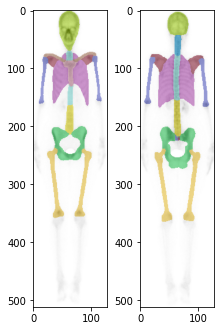

In [31]:
plt.figure(figsize=(15, n*3))
# for i in range(n):
    
plt.subplot(2, n*2, (2*i)+1)
plt.imshow(X_valid[vl_idx[i]][0].permute(1, 2, 0))
plt.imshow(map_clr(y_predv[vl_idx[i]][0].argmax(axis=0).numpy()), alpha=0.5)

plt.subplot(2, n*2, (2*i)+2)
plt.imshow(X_valid[vl_idx[i]][1].permute(1, 2, 0))
plt.imshow(map_clr(y_predv[vl_idx[i]][1].argmax(axis=0).numpy()), alpha=0.5)

    # plt.subplot(2, n*2, (n*2)+(2*i)+1)
    # plt.imshow(X_valid[vl_idx[i]][0].permute(1, 2, 0))
    # plt.imshow(map_clr(y_valid[vl_idx[i]][0].argmax(axis=0).numpy()), alpha=0.5)

    # plt.subplot(2, n*2, (n*2)+(2*i)+2)
    # plt.imshow(X_valid[vl_idx[i]][1].permute(1, 2, 0))
    # plt.imshow(map_clr(y_valid[vl_idx[i]][1].argmax(axis=0).numpy()), alpha=0.5)

# plt.savefig('./btr_2.png')